<div style="background-color:rgba(0,0,255,0.4); padding:10px 10px;">
This version adds statistic support.
</div>

In [474]:
# PACKAGES

In [475]:
##NECESSARY PACKAGES NEEDED FOR SIMULATION
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random
import simpy

# Utilities

In [476]:
#Checking absolute zero value by ε, which is declared to be 0.00001
def isZero(x, ε = 0.00001):
    return abs(x)<ε

## Bell Curve Random Generator

In [477]:
#Global declaration of Rounding off the values and random variables
gen_x_tab = None
gen_y_tab = None

def pdfv(x, mean=0, sd=None, delta=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275
    
    τ = math.sqrt(6)
    x = (x-mean)/sd*0.9275
    return np.where(abs(x)<τ, 5/(8*τ*sd)*(1-x**2/2+x**4/24+1/2)*0.9275, 0)

def rv(mean=0, sd=None, delta=None, alternating=None, rounding=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275

    global gen_count, gen_x_tab, gen_y_tab
    
    if gen_x_tab is None:
        
        # global variables are initialised
        gen_x_tab = list(np.linspace(-math.sqrt(6), -1.51, 500)) + \
                    list(np.linspace(-1.5, 0, 151)) 

        τ = math.sqrt(6)
        
        def cdf(x):
            return 5/(8*τ)*(x**5/120-x**3/6+x*3/2)+5/(8*τ)*(τ**5/120-τ**3/6+τ*3/2)
        
        gen_y_tab = [ cdf(x) for x in gen_x_tab ]
        
    y, sign = random.random(), 1
    if y>0.5:
        y, sign = 1-y, -1
    if alternating is not None:
        sign = 1 if alternating%2==0 else -1

    for i in range(1, len(gen_x_tab)):
        if y < gen_y_tab[i]:
            x0 = gen_x_tab[i]
            y0 = gen_y_tab[i]
            x1 = gen_x_tab[i-1]
            y1 = gen_y_tab[i-1]
            x = mean+sign*((x0+(y-y0)*(x1-x0)/(y1-y0))*sd/0.9275)
            if type(rounding) is int and rounding>0:
                return round(x, rounding)
            else:
                return x

In [478]:
## Lanes 

In [479]:
#CONSTRUCTING LANES THAT LEFT LANE DECLARES TO BE SLOW AND RIGHT LANE DECLARES TO BE FAST 
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [480]:
#CONSTRUCTING LANE CLASS
LANE_ID = 0

class Lane:
    
    def __init__(self, rec, length, speedLimit=None, merge=None):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
      
        self.rec = rec
        self.x0 = 0
        self.length = length
        
         # SPEEDLIMIT OF LANES in km/hr
        self.speedLimit = speedLimit 
        
        # DENOTES THE END OF LANE SHOULD MERGE EITHER IN LEFT OR RIGHT LANE
        self.merge = merge 
        
        #CREATING EMPTY LIST FOR VEHICLES
        self.vehicles = []
        
        #DENOTING LANE ATTACHED TO LEFT OR RIGHT
        self.next = None
        self.prev = None
        
        # lane attached to the left/right        
        self.left = None
        self.right = None
        
        rec.recordLane(self)
      
    #GENERIC STR() FOR LANES
    def __str__(self):
        l = " L:--" if self.left is None else f" L:{self.left.id:0>2d}"
        r = " R:--" if self.right is None else f" R:{self.right.id:0>2d}"
        s = "" if self.speedLimit is None else f" speedLimit:{self.speedLimit:d}km/h"
        return f"[{self.id:0>2d} x={self.x0:3.1f}m l={self.length:3.1f}m"+l+r+s+"]" + \
                    ("\\" if self.merge=='R' else "") + \
                    ("/" if self.merge=='L' else "") + \
                    ("-" + str(self.next) if self.next is not None else "")
    
     #GETTING LANE DIRECTION EITHER LEFT OR RIGHT WHICH DECIDES THE VEHICLE TO GO SLOW OR FAST
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None
        
     #ADDITION OF LANE PARALLELLY ON RIGHT SIDE 
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
 
    #ADDITION OF LANE PARALLELLY ON LEFT SIDE
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
     
     #BUILDING SAME LANE SEGMENTS AND ATTACHING TO THE RIGHT SIDE
    def widenRight(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
      #BUILDING SAME LANE SEGMENTS AND ATTACHING TO THE LEFT SIDE
    def widenLeft(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
            
     # EXTENDING THE LANE BY CONCATENATING ANOTHER LANE WITH THE CURRENT ONE
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.x0 = l.x0+l.length
        lane.prev = l
        return self
   
  #THE SUM OF THE LENGTH OF THE LANES  
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    #CALCULATING THE BETWEEN DISTANCE OF TWO CARS 
    def between(self, posBack, posFront):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if posBack < v.pos and v.pos-v.length < posFront:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if posFront > self.length and self.next is not None:
            return res + self.next.between(0, posFront-self.length)
        elif posBack < 0 and self.prev is not None:
            return self.prev.between(self.prev.length+posBack, self.prev.length) + res
        else:
            return res
        
    #CALCULATING THE FRONT DISTANCE OF TWO CARS 
    def inFront(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far-(self.length-pos))

    #CALCULATING THE BEHIND DISTANCE OF TWO CARS
    def behind(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far-pos)
    #CREATING ENTER LANE FUNCTION   
    def enter(self, vehicle, pos=0, laneChange=False):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane"+(f" {self.id:d}" if laneChange else ""))
    #CREATING LEAVE LANE FUNCTION
    def leave(self, vehicle, laneChange=False):
        vehicle.rec.record(vehicle, event="leave lane"+(f" {self.id:d}" if laneChange else ""))
        vehicle.lane = None
        self.vehicles.remove(vehicle)

## Vehicles

In [481]:
#CREATING A CLASS CALLED VEHICLE, THAT IS THE REPLICATE OF CLASS P
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [482]:
#CREATING A CLASS- VEHICLE
VEHICLE_ID = 0

class Vehicle:
    def __init__(self, rec, startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 vmax=None, vmax_var=None,
                 t=[], v=[],
                 vehicleType='FamilyCar'):
        
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        if vehicleType=='FamilyCar':
            self.a_brake = -4.0 # [m/s²]   Tesla: -8.0 # [m/s²]
            self.a_coast = -0.9 # [m/s²]   Tesla: -1.8 # [m/s²]   
            self.a_max =    3.2 # [m/s²]   Tesla:  4.6 # [m/s²] 
                                      # Note: 2.5m/s² corresponds to 0-100km/h om 11s
            self.length = 8 # [m]  Length of the vehicle 
            self.absolute_speed_time_tolerance = 2 # [s]
            self.relative_speed_time_tolerance = 5 # [s]
            self.far_away_in_front = 200 # [m]
            self.far_away_in_back = 80 # [m]
            self.min_action_time = 0.5 # [s]  

            self.lane_change_time = 3 # [s] 
            self.min_speed_diff = 2 # [m/s]
        
        elif vehicleType=='Tesla':
            self.a_brake = -8.0 # [m/s²]   Tesla: -8.0 # [m/s²]
            self.a_coast = -1.8 # [m/s²]   Tesla: -1.8 # [m/s²]   
            self.a_max =    4.6 # [m/s²]   Tesla:  4.6 # [m/s²] 
                                # Note: 2.5m/s² corresponds to 0-100km/h om 11s
            self.length = 4 # [m]  Length of the vehicle 
            self.absolute_speed_time_tolerance = 2 # [s]
            self.relative_speed_time_tolerance = 5 # [s]
            self.far_away_in_front = 200 # [m]
            self.far_away_in_back = 80 # [m]
            self.min_action_time = 0.5 # [s]  

            self.lane_change_time = 3 # [s] 
            self.min_speed_diff = 2 # [m/s]
        
        elif vehicleType=='HGV':
            self.a_brake = -10.2 # [m/s²]   Tesla: -8.0 # [m/s²]
            self.a_coast = -2.5 # [m/s²]   Tesla: -1.8 # [m/s²]   
            self.a_max =    1.2 # [m/s²]   Tesla:  4.6 # [m/s²] 
                                # Note: 2.5m/s² corresponds to 0-100km/h om 11s
            self.length = 12 # [m]  Length of the vehicle 
            self.absolute_speed_time_tolerance = 2 # [s]
            self.relative_speed_time_tolerance = 5 # [s]
            self.far_away_in_front = 400 # [m]
            self.far_away_in_back = 100 # [m]
            self.min_action_time = 1 # [s]  

            self.lane_change_time = 5 # [s] 
            self.min_speed_diff = 4 # [m/s]
        
        else:
            raise ValueError('Unknown VehicleType:' +vehicleType)
        
        ## if not None the preferred max free velocity
        self.vmax = vmax
        self.vmax_variation = vmax_var if vmax_var is not None else 0.05
        self.timing = 100 # [s]
        self.timing_variation = 0.30 
        
        self.env = rec.env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
         # SPEEDLIMIT FOR RECOGNIZE AT ONCE
        self.speedLimit = None
        
       ## REFERENCE FOR SECOND LANE WHILE CHANGING OF LANE
        self.oldLane = None
        
        self.alternator = 0
            
        self.t0 = t0
        self.x0 = x0   # IN FRONT OF THE VEHICLE, REFERENCE POINT OCCURS [m]
                        # BEHIND THE VEHICLE, THE BODY OF THE VEHICLE IS PRESENT
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0

        self.t_target = t
        self.v_target = v
        # ADJUSTING THE VELOCITY AND SETTING THE CURRENT TARGET
        self.current_target = None

        # TRACE MESSAGES FOR THE CLASS SURROUND
        self.traceAdjustVelocity = False
        self.traceInterrupt = False
        self.traceBraking = False
        self.traceCrash = False
        self.traceSurround = False
        self.traceOvertaking = False
 
        # PROCESS STARTS HERE
        self.running = False
        self.crashed = False
                
       # TEMPORARILY STARTING FLAG
        self.laneChangeControl = False 
                # FLAG FOR BLOCKING THE OVERTAKE
        self.braking = False
                 # FLAG TO PREVENT THE BRAKE INTERRUPTING
        self.changingLane = False
                # FLAG TO PREVENT THE LANE CHANGE
        
        self.processRef = None
        self.env.process(self.process())
    
    def trace(self, message):
        print(f"t={self.t0:7,.1f}s x={self.x0:7,.1f}m v{self.id:d}", message)
        
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    ## CHANGE THE INFORMATION IF LANE CHANGE NECESSARY
    def updateOnly(self):
        t = self.env.now
        if t < self.t0 or not self.running:
            return False
        if t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            self.pos = round(self.pos+Δx, 2)
            # UPDATE LANE IF NEEDED
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.oldLane = None
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
            
            
        return True
        
   
    def update(self):
        
        self.surround = Surround(self)
        
        ## CALL METHOD INSTEAD OF DIRECT
        inFront = self.surround.front
        
        #CHECKING RUNNING OR CRASHING IN FRONT
        if inFront is not None and inFront.x0-inFront.length < self.x0:
            self.crash(inFront)

        # CHECKING CHANGE IN SPEED LIMIT
        elif self.speedLimit != self.lane.speedLimit:
            self.speedLimit = self.lane.speedLimit
            if self.speedLimit is None:
                 #RESET TO DEFAULT SPEEDLIMIT
                if self.vmax is not None and self.vmax>self.dx0:
                    Δt = max(self.min_action_time, (self.vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, self.vmax)
            else:
                vmax = self.speedLimit/3.6
                vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                if vmax<self.dx0:
                    # COAST DOWN IF NEW SPEEDLIMIT IS LOWER THAN THE PRESENT ONE
                    Δt = max(self.min_action_time, (self.dx0-vmax)/self.a_coast)
                    self.setTarget(Δt, vmax)
                else:
                     # ACCELERATE AT HALF MAX IF NEW SPEEDLIMIT IS HIGHER THAN THE PRESENT ONE
                    Δt = max(self.min_action_time, 2*(vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, vmax)
                
         # CHECK IF MERGE REQUIRED AT THE END       
        elif self.lane.merge is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane:
            if self.lane.merge == 'R':
                if self.surround.rightLane is not None and \
                        self.surround.right is None and \
                        self.isNotFasterThan(self.surround.rightFront) and \
                        self.isNotSlowerThan(self.surround.rightBack):
                    self.setTarget(self.lane_change_time, 'fast')
            elif self.lane.merge == 'L':
                if self.surround.leftLane is not None and \
                        self.surround.left is None and \
                        self.isNotFasterThan(self.surround.leftFront) and \
                        self.isNotSlowerThan(self.surround.leftBack):
                    self.setTarget(self.lane_change_time, 'slow')                
        
        # CHANGE THE LANE FOR OVERTAKING
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 + self.min_speed_diff and \
                self.x0 + (self.lane_change_time+self.absolute_speed_time_tolerance)*self.dx0 > inFront.x0-inFront.length and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            self.setTarget(self.lane_change_time, 'fast')

        
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 and \
                self.x0 + self.absolute_speed_time_tolerance*self.dx0 > inFront.x0:
            # note that self.a_coast is a negative acceleration
            Δt = max(self.min_action_time, (inFront.dx0-self.dx0)/self.a_coast)
            if self.current_target is None or \
                    not isZero(self.current_target-inFront.dx0):
                self.setTarget(Δt, inFront.dx0)

         # CHANGE INTO SLOWER LANE, FOR NO OVERTAKING
        elif self.surround.leftLane is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.surround.leftLane.totalLength()-self.pos>100 and \
                self.surround.left is None and \
                self.isNotSlowerThan(self.surround.leftBack) and \
                self.surround.leftFront is None:
            self.setTarget(self.lane_change_time, 'slow')
     
    
    def setTarget(self, t, v):
        self.t_target = [ t ] + self.t_target
        self.v_target = [ v ] + self.v_target
        self.interruptProcess()
      
   
    def process(self):

         #DELAY THE START TIME
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = self.env.now
        self.running = True
        self.rec.startRecording(self)
        
        ## START THE FIRST LANE
        self.startingLane.enter(self)
        ## end additional code
        
        while self.updateOnly():

            
            inFront = self.lane.inFront(self.pos, self.far_away_in_front) \
                        if self.lane is not None else None
                
             #CHECK THE FRONT CAR IS SLOW OR NOT, IF SO WE ARE NEAR TO IT
            if inFront is not None and inFront.dx0 < self.dx0 and \
                    inFront.x0-inFront.length < \
                        self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0):
                yield from self.emergencyBraking(inFront.dx0)
                if not isZero(self.dx0-inFront.dx0):
                    #MODIFY THE SPEED AFTER EMERGENCY BRAKING
                    Δt = 1
                    self.setTarget(Δt, inFront.dx0)
                continue 
                    
            if len(self.t_target)>0:
                
                t_target = self.t_target[0]
                v_target = self.v_target[0]
                self.t_target = self.t_target[1:]
                self.v_target = self.v_target[1:]
                
                if type(v_target) is str:
                    
                    #NO OVERTAKE TEMPORARILY
                    if v_target=='R':
                        self.laneChangeControl = True
                    elif v_target=='L':
                        self.laneChangeControl = False
                        
                    direction = normaliseDirection(v_target)
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(inFront, direction, t_target)
                
                
                else:
                    v0 = self.dx0
                    v1 = v_target
                    Δt = t_target
                    if isZero(v1-v0):
                        yield from self.continueAtSameSpeed(Δt)
                    else:
                        yield from self.adjustVelocity(v1-v0, Δt)
                    
           
            elif self.vmax is not None:
                
               #SET THE MAX SPEED
                vmax = self.vmax
                if self.speedLimit is not None:
                    vmax = self.speedLimit/3.6
                    vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                 # CHECK IF THERE IS ENOUGH SPACE BETWEEN THE TWO CARS
                if inFront is None or \
                    self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0) < inFront.x0:
                    v0 = self.dx0
                    self.alternator += 1
                    v1 = rv(mean=vmax, 
                            delta=self.vmax_variation*vmax, 
                            alternating=self.alternator,
                            rounding=2)
                    Δt = rv(mean=self.timing, 
                            delta=self.timing*self.timing_variation,
                            rounding=1)
                
                    yield from self.adjustVelocity(v1-v0, Δt)
                else:
                    yield from self.continueAtSameSpeed(10)
            else:
                yield from self.continueAtSameSpeed(10)
                
        self.rec.stopRecording(self)

    def crash(self, other):
        
        def recordCrash(v):
            v.rec.record(v, 'crash')
            v.running = False
            v.crashed = True
            # stop anything your are currently doing...
            v.interruptProcess()
            v.dx0 = 0
            v.ddx0 = 0
            v.dddx0 = 0
            
        if self.running:
            if self.traceCrash:
                self.trace(f"Crashed into v{other.id:d} at x={self.x0:7.1f}m")
            recordCrash(self)
            if other.running:
                recordCrash(other)
        
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            
            if self.traceBraking:
                self.trace(f"Braking from v={self.dx0:4.1f}m/s to {v:4.1f}m/s")
           
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_brake-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_brake
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'brake end')
            
            if self.traceBraking:
                self.trace(f"Braking end  v={self.dx0:4.1f}m/s")

        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            if self.traceInterrupt or self.traceBraking:
                self.trace(f"Braking interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None
        self.braking = False
        
    def changeLane(self, inFront, direction, Δt):
     
        def changeLaneProcess(oldLane, newlane, Δt, trace=True):
            # self.updateOnly()
            if trace and self.traceOvertaking and inFront is not None and  direction=='fast':
                other = f"v{inFront.id:d} " if inFront is not None else ""
                self.trace(f"Overtaking {other:s} at x={self.x0:7,.1f}m")
                
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos, laneChange=True) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            
            self.updateOnly()
            if not self.running:
                return
            currentLane = self.lane
            self.oldLane.leave(self, laneChange=True)
            self.lane = currentLane
            self.oldLane = None
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'done change '+direction)
            
            if trace and self.traceOvertaking and direction=='slow':
                self.trace(f"Overtaking done return to slow lane at x={self.x0:7,.1f}m")
            # self.updateOnly()
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        self.changingLane = True
        self.updateOnly()
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            if self.traceInterrupt and self.traceOvertaking:
                self.trace(f"Overtaking interrupted at x={self.x0:7,.1f}m")
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.updateOnly()
            # it is possible that there was an intermittent change lane event
            while self.lane != newLane and newLane is not None:
                newLane = newLane.next
                oldLane = oldLane.next
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4, trace=False))
        self.changingLane = False    
        
    # smoothly adjust velocity by Δv over the time Δt
    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            
            self.updateOnly()
            
            if self.traceAdjustVelocity:
                self.trace(f"Adjusting Velocity from v={self.dx0:4,.1f}m/s by Δv={Δv:4,.1f}m/s over {Δt:4,.1f}s")
            
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt   
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
        
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
                    
            if self.traceAdjustVelocity:
                self.trace(f"Adjusted  Velocity to   v={self.dx0:4,.1f}m/s")
        
        # start process
        self.current_target = self.dx0 + Δv
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Adjusting Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.current_target = None
        self.processRef = None

    def continueAtSameSpeed(self, Δt):
        
        def continueAtSameSpeedProcess():
            # don't change the current velocity
            self.dddx0 = 0
            self.ddx0 = 0
            yield self.env.timeout(Δt)
        
        # start process
        self.processRef = self.env.process(continueAtSameSpeedProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Constant Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('There are more important things to do...')

# Surround

In [483]:
#Creating Surround class
class Surround:
    
    def __init__(self, vehicle):
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.vehicle = vehicle
            
        self.leftBack = None
        self.left = None
        self.leftFront = None
        self.back = None

        self.front = None
        self.rightBack = None
        self.right = None
        self.rightFront = None
        
        lane = vehicle.lane
        posFront = vehicle.pos
        posBack = vehicle.pos-vehicle.length
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(posFront, self.vehicle.far_away_in_front)
            self.back = lane.behind(posBack, self.vehicle.far_away_in_back)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.rightBack = self.rightLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    right = self.rightLane.between(posBack-10, posFront+10)
                    if len(right)==0:
                        # self.right = None
                        self.rightFront = self.rightLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.rightBack = self.rightLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.right = right[0]
                        # self.rightFront = None
                        # self.rightBack = None

            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.leftBack = self.leftLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    left = self.leftLane.between(posBack-10, posFront+10)
                    if len(left)==0:
                        # self.left = None
                        self.leftFront = self.leftLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.leftBack = self.leftLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.left = left[0]
                        # self.leftFront = None
                        # self.lefttBack = None
                    
        if vehicle.traceSurround:
            
            def s(vehicle):
                if vehicle is None:
                    return " "
                elif type(vehicle) is list:
                    if len(vehicle)==1:
                        return s(vehicle[0])
                    else:
                        res = "["
                        for v in vehicle:
                            if len(res)>1:
                                res += ','
                            res+=s(v)
                        res += "]"
                        return res
                else:
                    return f"{vehicle.id:d}"

            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# Recorder

[TOC](#Table-of-Contents)

In [484]:
#CREATE RECORDER CLASS
class Recorder:
    
    def __init__(self, startTime=0, stopTime=0, timeStep=1):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = simpy.Environment()
        self.ps = []
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # SIMULATION RUNS HERE
    def run(self):
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
    
    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()     
            yield self.env.timeout(self.timeStep)
            
    def startRecording(self, p):
        self.ps.append(p)
        self.record(p, event='start')
        
    def stopRecording(self, p):
        self.ps.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly() or event!='timer':
                laneId = -1 if p.lane is None else p.lane.id
                oldLaneId = -1 if p.oldLane is None else p.oldLane.id
                ix = len(self.data)
                self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, \
                                   laneId, oldLaneId, p.pos, event]
                if event=='timer':
                    p.update()
        else:
            for p in self.ps:
                self.record(p, event)

    #DETAIL OF RECORD LANE
    def recordLane(self, lane):
        ix = len(self.data)
        self.data.loc[ix]=[0, 0, 0, 0, 0, lane.id, -1, lane.length, 'lane info'] 

    #DETAIL OF LANE LENGTH
    def getLaneLength(self, laneId):
        lanes = self.data[self.data.event=='lane info']
        lane = lanes[lanes.lane==laneId]
        return lane.pos.iloc[0]
    
    def saveData(self, filename):
        self.data.to_csv(filename, index=False)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)
    
    ##CALCULATE THE TRAFFIC FLOW AT THE LANE END
    def flow(self, lane):
        df = self.data[self.data.event=='leave lane']
        df = df[df.lane==lane]
        if len(df)>1:
            # compensate for lane filling late or early running dry
            f = (len(df)-1)*3600/(df.t.max()-df.t.min())
            return round(f, 2)
        else:
            return 0

   ##CALCULATE THE AVERAGE TRAVELLING TIME 
    def avgTravelTime(self, laneId):
        d0 = self.data[self.data.event=='enter lane']
        d0 = d0[d0.lane==laneId]
        d1 = self.data[self.data.event=='leave lane']
        d1 = d1[d1.lane==laneId]
        times = []
        id0 = d0.id.unique()
        id1 = d1.id.unique()
        for id in id0:
            t0 = d0.t[d0.id==id].min()
            if id in id1:
                t1 = d1.t[d1.id==id].max()
                times += [ t1-t0 ]
        avg = 0
        if len(times)>0:
            avg = round(sum(times)/len(times), 2)
        return avg

    def avgSpeed(self, laneId):
        return round(3.6*self.getLaneLength(laneId)/self.avgTravelTime(laneId),2)
        
        
     #CALCULATE THE TRAFFIC DENSITY
    def density(self, laneId, time=None):
        timerEvents = self.data[self.data.event=='timer']
        times = timerEvents.t.unique()
        laneEvents = timerEvents[timerEvents.lane==laneId]
        laneLength = self.getLaneLength(laneId)
        
        if time is None:
            densities = []
            for t in times:
                events = laneEvents[laneEvents.t==t]
                d = len(events)*1000/laneLength
                densities.append(round(d,2))
            return sum(densities)/len(densities)
        
         #CALCULATE TIME STAMP OVER THE TIME
        if time in times:
            t = time
        else:
            #TAKE NEAR POINT IN TIME
            diff = list((times-time)**2)
            t = times[diff.index(min(diff))]
        events = laneEvents[laneEvents.t==t]
        d = len(events)*1000/laneLength
        return round(d,2)
    
    #CREATE FUNCTION FOR THE PLOTTING
    def plot(self, x, y, 
             vehicles=None, style='', lw=1, decoration=True,
             x0=None, x1=None, y0=None, y1=None, fillColor=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(5, 3), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, style, lw=lw, data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            if not decoration:
                continue
            
            #SMALL RED CIRLCLE FOR INDICATING EMERGENCY BRAKE
            dc = df[df.event=='brake']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')
                            
            db = df[df.event=='brake end']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], marker='o', mec='r', fillstyle='none')

            # BLACK "X" MARK FOR INDICATING CRASH
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
                
             # BLACK DIAMOND INDICATES THAT THE VEHICLE WENT OUT OF TRACK 
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
             # BLACK RIGHT POINTING FULL TRIANGLE THAT INDICATES THAT THE VEHICLE STARTS TO CHANGE INTO FAST LANE 
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # BLACK LEFT POINTING FULL TRIANGLE THAT INDICATES THAT THE VEHICLE FINISHES TO CHANGE THE SLOW LANE 
            dc = df[df.event=='done change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='>', mec='k', fillstyle='none')

            # BLACK RIGHT POINTING HOLLOW TRIANGLE THAT INDICATES THAT THE VEHICLE FINISHES TO CHANGE THE FAST LANE 
            dc = df[df.event=='change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # BLACK LEFT POINTING HOLLOW TRIANGLE THAT INDICATES THAT THE VEHICLE FINISHES TO CHANGE THE SLOW LANE 
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='<', mec='k', fillstyle='none')
            
        # FILLS THE BACKGROUND COLOUR
        if fillColor is not None:
            if x0 is None:
                x0=self.data[x].min()
            if x1 is None:
                x1=self.data[x].max()
            if y0 is None:
                y0=self.data[y].min()
            if y1 is None:
                y1=self.data[y].max()
            plt.fill_between( [x0, x1], [y0, y0], [y1, y1], color=fillColor)
            
        plt.grid(True)

## Load Data

In [485]:
#LOAD THE DATA
def loadData(filename):  
    data = pd.read_csv(filename)
    r = Recorder()
    if list(data.columns) == list(r.data.columns):
        r.data = data
        return r
    else:
        return None

## Comparing Data

In [486]:
def sameData(r1, r2):
    try:
        return all(r1.getData() == r2.getData())
    except ValueError:
        return False

# THREE LANE TO TWO LANE MERGING CONSTRUCTION OF MOTORWAY

In [487]:
VMAX = 120/3.6

# Vehicles on the Motorway
N = 60 #NUMBER OF VEHICLES   #N AND IAT ARE CHANGED TO RUN VARIOUS SIMULATIONS THAT ARE MENTIONED IN THE REPORT 
IAT =20 #INTER-ARRIVAL TIME

rec = Recorder(0, 1400, 1) #ALSO STOP TIME HAS CHANGED TO GET DIFFERENT RESULTS

#CREATING LEFT LANE
l = Lane(rec, 1000,speedLimit=60)
#EXTENDING LEFT LANE BY L1
l1 = Lane(rec, 1000,speedLimit=60)
#EXTENDING AGAIN THE LEFT LANE BY L2
l2= Lane(rec,1000)
l.extend(l1)
l.extend(l2)
#WIDEN THE RIGHT LANE SAME AS LEFT LANE
r = l.widenRight()

#CREATING ONRAMP AND MERGE LANE
onRamp = Lane(rec, 1000)
mergeLane = Lane(rec, 1000, merge='R')
onRamp.extend(mergeLane)

l1.attachLeft(mergeLane)
l1.left = None  # don't move from the Motorway onto the on-ramp/merge lane
print(onRamp)
print(l)
print(r)



iat= [ rv(IAT,delta=0.4+IAT) for i in range(N) ]
t=0

 

lanes=[onRamp,l,r]
previousLane=None

 

for i in range(N):
    
    
    t+=iat[i]
    u=random.random()
    #USING RANDOM FUNCTION TO CHOSE THE LANE
    sequence = [0,3,6]
    previousLane= random.choice(sequence)
    if previousLane==None or previousLane==6:
        chosenLane=onRamp
    elif  previousLane==0 :
        chosenLane=l
    elif previousLane==3 :
        chosenLane=r
    
#TRAFFIC MIX(3 TYPES OF VEHICLES SUCH AS HGV, TESLA, FAMILYCAR)
    if u<=0.15:
        v=Vehicle(rec,startingLane=chosenLane,t0=t,dx0=80/3.6,
                 vmax=VMAX,vehicleType='HGV'  )
        v.traceCrash = True    
        v.traceBraking = True
        v.traceOvertaking=True
        v.traceAdjustVelocity=True
    elif u<=0.25:
        v=Vehicle(rec,startingLane=chosenLane,t0=t,dx0=120/3.6,
                 vmax=VMAX,vehicleType='Tesla'  )
        v.traceCrash = True
        v.traceBraking = True
        v.traceOvertaking=True
        v.traceAdjustVelocity=True
    else:
        v=Vehicle(rec,startingLane=chosenLane,t0=t,dx0=100/3.6,
                 vmax=VMAX,vehicleType='FamilyCar')
    
        v.traceCrash = True
        v.traceBraking = True
        v.traceOvertaking=True
        v.traceAdjustVelocity=True
    
    previousLane=chosenLane
rec.run()



[06 x=0.0m l=1000.0m L:-- R:--]-[07 x=1000.0m l=1000.0m L:-- R:01 speedLimit:60km/h]\
[00 x=0.0m l=1000.0m L:-- R:03 speedLimit:60km/h]-[01 x=1000.0m l=1000.0m L:-- R:04 speedLimit:60km/h]-[02 x=2000.0m l=1000.0m L:-- R:05]
[03 x=0.0m l=1000.0m L:00 R:-- speedLimit:60km/h]-[04 x=1000.0m l=1000.0m L:01 R:-- speedLimit:60km/h]-[05 x=2000.0m l=1000.0m L:02 R:--]
t=   32.0s x=    0.0m v0 Adjusting Velocity from v=27.8m/s by Δv= 6.5m/s over 109.0s
t=   32.0s x=    1.1m v0 Adjusting Velocity from v=27.8m/s by Δv=-11.5m/s over  0.5s
t=   32.5s x=   12.1m v0 Adjusted  Velocity to   v=16.3m/s
t=   32.5s x=   12.1m v0 Adjusting Velocity from v=16.3m/s by Δv= 0.5m/s over 83.3s
t=   36.0s x=    0.0m v1 Adjusting Velocity from v=27.8m/s by Δv= 5.8m/s over 104.1s
t=   37.0s x=   26.9m v1 Braking from v=27.8m/s to 16.3m/s
t=   40.1s x=   94.5m v1 Braking end  v=16.3m/s
t=   40.1s x=   94.5m v1 Adjusting Velocity from v=16.3m/s by Δv= 0.0m/s over  1.0s
t=   41.1s x=  110.8m v1 Adjusted  Velocity to   

t=  306.0s x=1,162.2m v11 Adjusting Velocity from v=22.3m/s by Δv=-6.0m/s over 100.3s
t=  308.2s x=1,934.9m v9 Adjusted  Velocity to   v=16.7m/s
t=  308.2s x=1,934.9m v9 Adjusting Velocity from v=16.7m/s by Δv= 0.6m/s over 111.4s
t=  313.0s x=2,014.8m v9 Adjusting Velocity from v=16.7m/s by Δv=16.7m/s over 13.9s
t=  240.0s x=3,019.7m v5 Adjusted  Velocity to   v=33.4m/s
t=  316.1s x=    0.0m v13 Adjusting Velocity from v=27.8m/s by Δv= 6.1m/s over 116.9s
t=  317.0s x=1,410.6m v11 Overtaking done return to slow lane at x=1,410.6m
t=  317.0s x=1,410.6m v11 Adjusting Velocity from v=25.1m/s by Δv=-8.3m/s over 127.2s
t=  317.0s x=   24.3m v13 Adjusting Velocity from v=27.8m/s by Δv=-10.5m/s over  0.5s
t=  317.5s x=   35.6m v13 Adjusted  Velocity to   v=17.3m/s
t=  317.5s x=   35.6m v13 Adjusting Velocity from v=17.3m/s by Δv=-0.3m/s over 108.1s
t=  321.0s x=  100.7m v13 Overtaking done return to slow lane at x=  100.7m
t=  321.0s x=  100.7m v13 Adjusting Velocity from v=20.3m/s by Δv=-3.4m

t=  539.0s x=1,016.5m v21 Adjusting Velocity from v=27.1m/s by Δv=-10.3m/s over  1.0s
t=  539.3s x=2,138.6m v17 Adjusted  Velocity to   v=33.3m/s
t=  539.3s x=2,138.6m v17 Adjusting Velocity from v=33.3m/s by Δv=-0.4m/s over 97.5s
t=  540.0s x=1,038.4m v21 Adjusted  Velocity to   v=16.8m/s
t=  540.0s x=1,038.4m v21 Adjusting Velocity from v=16.8m/s by Δv=-0.1m/s over 112.3s
t=  548.7s x=1,519.9m v19 Adjusted  Velocity to   v=16.5m/s
t=  548.7s x=1,519.9m v19 Adjusting Velocity from v=16.5m/s by Δv= 0.2m/s over 103.3s
t=  485.0s x=3,007.0m v15 Adjusted  Velocity to   v=33.3m/s
t=  565.9s x=    0.0m v24 Adjusting Velocity from v=27.8m/s by Δv= 6.2m/s over 100.3s
t=  566.0s x=2,004.9m v18 Adjusting Velocity from v=17.1m/s by Δv=16.2m/s over 13.5s
t=  566.0s x=    3.8m v24 Adjusting Velocity from v=27.8m/s by Δv=-11.0m/s over  0.5s
t=  566.5s x=   15.0m v24 Adjusted  Velocity to   v=16.7m/s
t=  566.5s x=   15.0m v24 Adjusting Velocity from v=16.7m/s by Δv=-0.1m/s over 116.0s
t=  577.0s x=1

t=  725.0s x=   23.9m v34 Adjusted  Velocity to   v=16.5m/s
t=  725.0s x=   23.9m v34 Adjusting Velocity from v=16.5m/s by Δv= 0.1m/s over 119.6s
t=  727.3s x=2,142.3m v26 Adjusted  Velocity to   v=33.3m/s
t=  727.3s x=2,142.3m v26 Adjusting Velocity from v=33.3m/s by Δv= 0.2m/s over 91.4s
t=  640.0s x=3,022.3m v20 Adjusted  Velocity to   v=33.2m/s
t=  734.0s x=2,016.3m v28 Adjusting Velocity from v=17.9m/s by Δv=15.4m/s over  4.8s
t=  736.0s x=1,028.6m v32 Adjusting Velocity from v=29.8m/s by Δv=-13.1m/s over  0.5s
t=  736.5s x=1,040.2m v32 Adjusted  Velocity to   v=16.7m/s
t=  736.5s x=1,040.2m v32 Adjusting Velocity from v=16.7m/s by Δv=-0.6m/s over 97.1s
t=  737.0s x=1,048.6m v32 Overtaking v31  at x=1,048.6m
t=  738.8s x=2,139.7m v28 Adjusted  Velocity to   v=33.3m/s
t=  738.8s x=2,139.7m v28 Adjusting Velocity from v=33.3m/s by Δv=-0.7m/s over 83.9s
t=  740.0s x=1,103.2m v32 Adjusting Velocity from v=19.7m/s by Δv=-3.3m/s over 108.6s
t=  672.0s x=3,004.1m v22 Adjusted  Velocity t

t=  789.0s x=2,195.9m v31 Adjusting Velocity from v=33.3m/s by Δv=-0.0m/s over  0.5s
t=  789.5s x=2,212.6m v31 Adjusted  Velocity to   v=33.3m/s
t=  789.5s x=2,212.6m v31 Adjusting Velocity from v=33.3m/s by Δv= 0.5m/s over 107.0s
t=  790.0s x=2,229.2m v31 Adjusting Velocity from v=33.3m/s by Δv=-0.0m/s over  0.5s
t=  790.5s x=2,245.9m v31 Adjusted  Velocity to   v=33.3m/s
t=  790.5s x=2,245.9m v31 Adjusting Velocity from v=33.3m/s by Δv=-0.9m/s over 106.6s
t=  718.0s x=3,027.9m v24 Adjusted  Velocity to   v=33.1m/s
t=  791.0s x=2,262.6m v31 Adjusting Velocity from v=33.3m/s by Δv=-0.0m/s over  0.5s
t=  791.5s x=2,279.2m v31 Adjusted  Velocity to   v=33.3m/s
t=  791.5s x=2,279.2m v31 Adjusting Velocity from v=33.3m/s by Δv= 1.2m/s over 96.5s
t=  792.0s x=2,295.9m v31 Adjusting Velocity from v=33.3m/s by Δv=-0.0m/s over  0.5s
t=  792.5s x=2,312.6m v31 Adjusted  Velocity to   v=33.3m/s
t=  792.5s x=2,312.6m v31 Adjusting Velocity from v=33.3m/s by Δv=-0.1m/s over 108.5s
t=  792.7s x=2,13

t=  812.5s x=3,010.4m v30 Adjusted  Velocity to   v=33.2m/s
t=  871.0s x=1,559.0m v37 Adjusting Velocity from v=19.5m/s by Δv=-3.0m/s over 108.0s
t=  803.0s x=3,002.9m v29 Adjusted  Velocity to   v=33.2m/s
t=  819.0s x=3,014.8m v32 Adjusted  Velocity to   v=33.2m/s
t=  888.2s x=1,817.4m v36 Adjusted  Velocity to   v=16.4m/s
t=  888.2s x=1,817.4m v36 Adjusting Velocity from v=16.4m/s by Δv= 0.1m/s over 89.3s
t=  891.4s x=    0.0m v41 Adjusting Velocity from v=33.3m/s by Δv= 0.1m/s over 94.1s
t=  894.0s x=2,002.9m v37 Adjusting Velocity from v=19.0m/s by Δv=14.4m/s over  4.5s
t=  898.5s x=2,120.3m v37 Adjusted  Velocity to   v=33.3m/s
t=  898.5s x=2,120.3m v37 Adjusting Velocity from v=33.3m/s by Δv=-0.1m/s over 99.9s
t=  900.0s x=2,010.6m v36 Adjusting Velocity from v=16.4m/s by Δv=17.0m/s over  3.7s
t=  902.3s x=    0.0m v42 Adjusting Velocity from v=27.8m/s by Δv= 5.9m/s over 99.7s
t=  903.0s x=   20.4m v42 Adjusting Velocity from v=27.8m/s by Δv=-11.2m/s over  0.5s
t=  903.5s x=   31

t=1,003.0s x=3,031.3m v41 Adjusted  Velocity to   v=33.4m/s
t=1,071.2s x=    0.0m v51 Adjusting Velocity from v=27.8m/s by Δv= 6.5m/s over 85.6s
t=1,072.5s x=1,796.9m v46 Adjusted  Velocity to   v=16.7m/s
t=1,072.5s x=1,796.9m v46 Adjusting Velocity from v=16.7m/s by Δv=-0.6m/s over 82.9s
t=1,085.0s x=2,005.1m v46 Adjusting Velocity from v=16.6m/s by Δv=16.7m/s over  5.2s
t=1,003.0s x=3,000.2m v39 Adjusted  Velocity to   v=33.3m/s
t=1,090.2s x=2,135.6m v46 Adjusted  Velocity to   v=33.3m/s
t=1,090.2s x=2,135.6m v46 Adjusting Velocity from v=33.3m/s by Δv= 0.2m/s over 120.0s
t=1,013.0s x=3,018.3m v40 Adjusted  Velocity to   v=33.4m/s
t=1,101.2s x=    0.0m v52 Adjusting Velocity from v=27.8m/s by Δv= 6.0m/s over 89.0s
t=1,102.0s x=   22.9m v52 Adjusting Velocity from v=27.8m/s by Δv=-11.0m/s over  0.5s
t=1,102.5s x=   34.0m v52 Adjusted  Velocity to   v=16.8m/s
t=1,102.5s x=   34.0m v52 Adjusting Velocity from v=16.8m/s by Δv=-1.2m/s over 87.8s
t=1,103.4s x=1,743.9m v47 Adjusted  Velocit

t=1,316.0s x=1,904.8m v59 Adjusting Velocity from v=18.4m/s by Δv=-1.6m/s over  1.8s
t=1,317.8s x=1,935.8m v59 Adjusted  Velocity to   v=16.8m/s
t=1,317.8s x=1,935.8m v59 Adjusting Velocity from v=16.8m/s by Δv=-0.1m/s over 87.8s
t=1,318.9s x=1,989.9m v57 Adjusted  Velocity to   v=16.8m/s
t=1,318.9s x=1,989.9m v57 Adjusting Velocity from v=16.8m/s by Δv=-1.1m/s over 119.7s
t=1,320.0s x=2,008.4m v57 Adjusting Velocity from v=16.8m/s by Δv=16.5m/s over  5.2s
t=1,322.0s x=2,007.1m v59 Adjusting Velocity from v=16.8m/s by Δv=16.5m/s over  5.2s
t=1,325.2s x=2,137.8m v57 Adjusted  Velocity to   v=33.3m/s
t=1,325.2s x=2,137.8m v57 Adjusting Velocity from v=33.3m/s by Δv= 1.0m/s over 98.8s
t=1,327.2s x=2,136.5m v59 Adjusted  Velocity to   v=33.3m/s
t=1,327.2s x=2,136.5m v59 Adjusting Velocity from v=33.3m/s by Δv= 0.3m/s over 90.3s
t=1,340.0s x=2,004.6m v58 Adjusting Velocity from v=20.2m/s by Δv=13.1m/s over 10.9s
t=1,257.0s x=3,020.8m v52 Adjusted  Velocity to   v=33.2m/s
t=1,350.9s x=2,297.

In [488]:
#GETTING DATA
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,0,0,0,0,-1,1000,lane info
1,0,0,0,0,0,1,-1,1000,lane info
2,0,0,0,0,0,2,-1,1000,lane info
3,0,0,0,0,0,3,-1,1000,lane info
4,0,0,0,0,0,4,-1,1000,lane info
...,...,...,...,...,...,...,...,...,...
8962,1370,2931.68,33.259271,-0.003272,58,2,-1,931.68,timer
8963,1371,2964.94,33.255999,-0.003272,58,2,-1,964.94,timer
8964,1372,2998.19,33.252727,-0.003272,58,2,-1,998.19,timer
8965,1373,3031.44,33.249456,-0.003272,58,2,-1,1031.44,leave lane


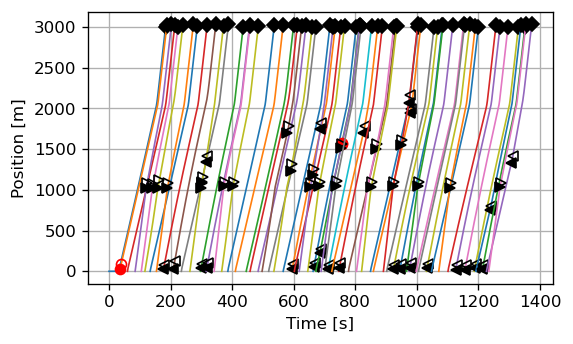

In [489]:
#PLOTTING POSITION TIME GRAPH
rec.plot('t','x')

In [490]:
#FINDING THROUGHPUT BY CREATING A FUNCTION
def throughput():
    data=rec.getData()
    last_end_time=rec.getData()[data.event=="end"].iloc[-1]['t']
    start_end_time=rec.getData()[data.event=="end"].iloc[0]['t']
    totalcar_end=len(rec.getData()[data.event=="end"])
    throughput=totalcar_end/((last_end_time-start_end_time)/3600)
    return throughput
    throughput_val=throughput()
    throughput_val

In [491]:
throughput()

181.66526492851136

In [492]:
#IMPORTING HMEAN INBUILT FUNCTION (FOR CALCULATING HARMONIC MEAN)
from scipy.stats import hmean

# Density

In [493]:
#CALCULATING DENSITY
[rec.density(0)+rec.density(1)+rec.density(2)+rec.density(3)+rec.density(4)+rec.density(5)]

[5.5779269202087995]

# AVERAGE SPEED

In [495]:
#CALCULATING AVERAGE SPEED
mean_speed =hmean([rec.avgSpeed(0), rec.avgSpeed(1), rec.avgSpeed(2),rec.avgSpeed(3)])
mean_speed

67.76876407115776

# TRAFFIC FLOW

In [496]:
##TRAFFIC FLOW AT THE END OF THE LEFT LANE

In [497]:
a = hmean([rec.flow(0), rec.flow(1), rec.flow(2)])

In [498]:
##TRAFFIC FLOW AT THE END OF THE RIGHT LANE

In [499]:
b = hmean([rec.flow(3), rec.flow(4), rec.flow(5)])

In [500]:
##TRAFFIC FLOW AT THE END OF THE ON-RAMP LANE

In [501]:
c = hmean([rec.flow(6), rec.flow(7)])

In [502]:
#TOTAL TRAFFIC FLOW
totaltraffic_flow = a+b+c
totaltraffic_flow

149.50616161272723

# AVERAGE TRAVEL TIME

In [503]:
#CALCULATING AVERAGE TRAVEL TIME
time_lane_1 = ([rec.avgTravelTime(0), rec.avgTravelTime(1), rec.avgTravelTime(2)])
time_lane_2 = ([rec.avgTravelTime(3), rec.avgTravelTime(4), rec.avgTravelTime(5)])
time_lane_3 = ([rec.avgTravelTime(6), rec.avgTravelTime(7)])

avg_travel_time = np.mean([time_lane_1 + time_lane_2 +time_lane_3])
avg_travel_time

30.995